# Credit Risk Resampling Techniques

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay 
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

# Read the CSV and Perform Basic Data Cleaning

In [20]:
file_path = Path('./Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,20000.0,20000.0,20000.0,60 months,17.19%,499.10,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,21225.0,21225.0,21225.0,60 months,14.74%,502.05,C,C2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000.0,5000.0,5000.0,36 months,17.97%,180.69,D,D1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,20000.0,20000.0,20000.0,36 months,8.19%,628.49,A,A4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,12000.0,12000.0,12000.0,60 months,15.57%,289.09,C,C3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115670,NaN,NaN,5000.0,5000.0,5000.0,36 months,13.56%,169.83,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
115671,NaN,NaN,6000.0,6000.0,6000.0,36 months,6.46%,183.79,A,A1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
115672,NaN,NaN,16000.0,16000.0,16000.0,36 months,16.14%,563.62,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
115673,NaN,NaN,16000.0,16000.0,16000.0,60 months,11.31%,350.36,B,B3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [22]:
# Load the data
file_path = Path('./Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [23]:
# drop columns with one value
df = df.drop(columns=['debt_settlement_flag', 'hardship_flag', 'pymnt_plan'])
df

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,0.0,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,10000.0,0.1502,346.76,RENT,26000.0,Source Verified,Jan-2019,low_risk,9.60,0.0,...,0.0,3.0,80.0,0.0,0.0,0.0,20625.0,6798.0,11300.0,5425.0
68813,12000.0,0.2727,368.37,RENT,63000.0,Not Verified,Jan-2019,low_risk,29.07,0.0,...,0.0,5.0,96.2,0.0,0.0,0.0,87939.0,60350.0,13500.0,62939.0
68814,5000.0,0.1992,185.62,MORTGAGE,52000.0,Source Verified,Jan-2019,low_risk,14.86,0.0,...,0.0,3.0,100.0,0.0,1.0,0.0,30592.0,18611.0,3600.0,18492.0
68815,40000.0,0.0646,1225.24,MORTGAGE,520000.0,Verified,Jan-2019,low_risk,9.96,0.0,...,0.0,3.0,98.2,12.5,0.0,0.0,1033574.0,95958.0,100800.0,78634.0


In [24]:
df.shape

(68817, 83)

In [25]:
clean_df = df

clean_df.to_csv("./Resources/clean_df.csv", index=False)

In [26]:
df = pd.read_csv("./Resources/clean_df.csv")
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,27.24,0.0,...,0.0,3.0,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,20.23,0.0,...,0.0,6.0,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,24.26,0.0,...,0.0,4.0,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,31.44,0.0,...,0.0,1.0,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,18.76,0.0,...,0.0,1.0,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0


# Split the Data into Training and Testing

In [31]:
# Create our features
X = df.drop(columns='loan_status')


# Create our target
y = df['loan_status']
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [29]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,2.000000,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,3.000000,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,18.000000,19.000000,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06


In [33]:
#get_dummies to convert objects into integer
X_encoded = pd.get_dummies(X)
X_encoded.shape

(68817, 92)

In [34]:
y.shape

(68817,)

In [40]:
# scale 
data_scaler = StandardScaler()

In [41]:
# fit and trasnform 
X_encoded_scaled = data_scaler.fit_transform(X_encoded)
X_encoded_scaled[:5]

array([[-6.01092723e-01,  9.17984364e-01, -3.65558353e-01,
        -1.92194797e-01,  2.70400563e-01, -3.03142532e-01,
        -6.56491511e-01, -7.61659174e-01, -3.74204323e-01,
        -7.32521829e-01, -8.65857295e-01, -5.81245133e-01,
        -5.80819581e-01, -5.00465445e-01, -5.00293345e-01,
        -3.22863900e-01, -8.99604190e-01, -3.22736265e-02,
         0.00000000e+00,  0.00000000e+00, -1.73835281e-01,
        -1.20112470e-01,  0.00000000e+00,  0.00000000e+00,
        -5.89694662e-03, -7.26922276e-01,  1.67997825e+00,
         2.39253304e-01,  1.19137226e+00,  1.35299632e+00,
        -8.08956027e-01, -1.34187152e-01, -4.57175710e-01,
        -1.63101750e-01, -2.48640217e-01, -8.32039942e-01,
         1.24221966e-01, -1.04213361e+00, -2.47582393e-01,
        -5.91660154e-01,  7.55780406e-01,  3.72749228e-01,
        -5.90524188e-01, -8.09152878e-01,  1.04494582e+00,
        -7.82090839e-02, -7.78953140e-03, -5.69940224e-01,
        -7.98162796e-01, -6.48459594e-01, -6.63139469e-0

In [42]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y, random_state = 1)

In [43]:
y_train.value_counts()

low_risk     51366
high_risk      246
Name: loan_status, dtype: int64

In [45]:
#Initiate a logistic regression model 
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier

LogisticRegression(random_state=1)

In [46]:
#train the model
classifier.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [57]:
y_pred= classifier.predict(X_test)
y_pred

array(['low_risk', 'low_risk', 'low_risk', ..., 'low_risk', 'low_risk',
       'low_risk'], dtype=object)

In [58]:
pd.DataFrame({"Prediction": y_pred, "Actual": y_test})

,Prediction,Actual
7034,low_risk,low_risk
38804,low_risk,low_risk
65533,low_risk,low_risk
37736,low_risk,low_risk
6390,low_risk,low_risk
...,...,...
31854,low_risk,low_risk
27835,low_risk,low_risk
3089,low_risk,low_risk
43343,low_risk,low_risk


In [60]:
accuracy_score(y_test, y_pred)

0.995059575704737

In [61]:
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[   21    80]
 [    5 17099]]


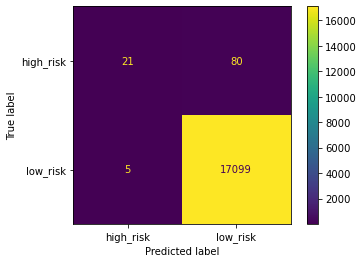

In [68]:
disp = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = classifier.classes_)
disp.plot()

In [69]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   high_risk       0.81      0.21      0.33       101
    low_risk       1.00      1.00      1.00     17104

    accuracy                           1.00     17205
   macro avg       0.90      0.60      0.66     17205
weighted avg       0.99      1.00      0.99     17205



In [72]:
report = classification_report_imbalanced(y_test, y_pred)
print(report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.81      0.21      1.00      0.33      0.46      0.19       101
   low_risk       1.00      1.00      0.21      1.00      0.46      0.22     17104

avg / total       0.99      1.00      0.21      0.99      0.46      0.22     17205



# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [74]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [75]:
# Train the Logistic Regression model using the resampled data

classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [79]:
y_pred = classifier.predict(X_test)


In [80]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8325468421491353

In [81]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   83,    18],
       [ 2680, 14424]], dtype=int64)

In [82]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.82      0.84      0.06      0.83      0.69       101
   low_risk       1.00      0.84      0.82      0.91      0.83      0.69     17104

avg / total       0.99      0.84      0.82      0.91      0.83      0.69     17205



### SMOTE Oversampling

In [110]:
# Resample the training data with SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)

Counter(y_resampled)

Counter({'low_risk': 51366, 'high_risk': 51366})

In [111]:
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)


LogisticRegression(random_state=1)

In [112]:
# Train the Logistic Regression model using the resampled data
# YOUR CODE HERE

In [113]:
y_pred = model.predict(X_test)


In [114]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8440938486973113

In [115]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   83,    18],
       [ 2285, 14819]], dtype=int64)

In [116]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.82      0.87      0.07      0.84      0.71       101
   low_risk       1.00      0.87      0.82      0.93      0.84      0.72     17104

avg / total       0.99      0.87      0.82      0.92      0.84      0.72     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [117]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)


In [118]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

In [119]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8203882595930314

In [120]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   89,    12],
       [ 4112, 12992]], dtype=int64)

In [121]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.88      0.76      0.04      0.82      0.68       101
   low_risk       1.00      0.76      0.88      0.86      0.82      0.66     17104

avg / total       0.99      0.76      0.88      0.86      0.82      0.66     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [128]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
# X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high_risk': 51366, 'low_risk': 47640})

In [129]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

In [130]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.844016280135965

In [131]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   84,    17],
       [ 2457, 14647]], dtype=int64)

In [133]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.83      0.86      0.06      0.84      0.71       101
   low_risk       1.00      0.86      0.83      0.92      0.84      0.71     17104

avg / total       0.99      0.86      0.83      0.92      0.84      0.71     17205

